#1) Accuracy: Accuracy averaged 75.5% over all categories. This was after ~12 hours of training on Google Colab.

#2) See confusion matrix (heatmap) below.

#3) See normalized confusion matrix (heatmap) below.

#4) Class 5 (Itsukushima Shrine, Japan) is most accurate per the maximum value on the normalized confusion matrix.

#5) Class 6 (Shanghai, China) is the least accurate per the diagonal of the matrix. The model here seems most confused by Montreal, Canada, and Brisbane, Australia (both at around a 25% error rate per the matrix.) 

#6) See bar chart at end of document for precision and recall with respect to categorical predictions.

#Just for fun) See other Jupyter notebook for Tensorflow implementation (no need to grade).

In [1]:
import pandas as pd
import numpy as np
import shutil, os

test = pd.read_csv('HW3_test.csv',header = None)
train = pd.read_csv('HW3_train.csv', header = None)
#id, url, landmark_id are columns
#id corresponds to name of .jpg

test.columns = ['id','url','landmark_id']
train.columns = ['id','url','landmark_id']

#removing URL column

test = test[['id','landmark_id']]
train = train[['id','landmark_id']]

#adding extension to id to match filenames
test['id'] = test['id'] + '.jpg'
train['id'] = train['id'] + '.jpg'




In [2]:
test.head()

,id,landmark_id
0,7e15276b0cbe4226.jpg,6
1,210384b6a647ac43.jpg,6
2,2a6b356a071e148d.jpg,5
3,3d92bd75d9691769.jpg,4
4,6bc5ddacc2bf537d.jpg,4


In [2]:
train.head()


,id,landmark_id
0,6591289cabd732f4.jpg,1
1,8f2b466365e50d6d.jpg,8
2,2fe21b965b35da1c.jpg,5
3,45173683aa7d1ae6.jpg,0
4,a0057b550dbea8e2.jpg,8


In [3]:
#subsetting images into proper folders per Transfer Learning Tutorial format
landmarks = {0:"St. Stephan's Cathedral, Austria",
             1:"Teide, Spain",
             2:"Tallinn, Estonia",
             3:"Brugge, Belgium",
             4:"Montreal, Canada",
             5:"Itsukushima Shrine, Japan",
             6:"Shanghai, China",
             7:"Brisbane, Australia",
             8:"Edinburgh, Scotland",
             9:"Stockholm, Sweden"}

#copying test images.
for k,_ in enumerate(landmarks): #range over all labels
    for _, row in test.iterrows():
        if row.landmark_id == k:
            shutil.copy(src = f'images/{row.id}', dst = f'data/val/{k}')

#copying training images
for k,_ in enumerate(landmarks): #range over all labels
    for _, row in train.iterrows():
        if row.landmark_id == k:
            shutil.copy(src = f'images/{row.id}', dst = f'data/val/{k}')

In [4]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode


In [5]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#loading data

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

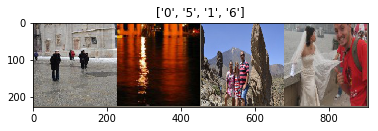

In [6]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10) #setting 10 = number of classes

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# Adapted from: 
    # License: BSD
    # Author: Sasank Chilamkurthy
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10) #set to 10 epochs such that Google Colab would not time-out.

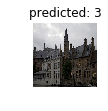

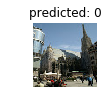

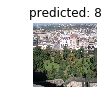

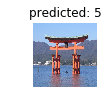

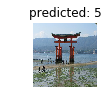

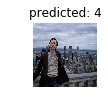

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [12]:
# This snippet adapted from PyTorch Forum:
# https://discuss.pytorch.org/t/how-to-check-and-read-confusion-matrix/41835/3

def update_confusion_matrix(preds, labels, conf_matrix):
    """This function will update a confusion matrix once given a new
    set of labels and predicted values"""
    preds = torch.max(preds, 1)[1]
    for t, p in zip(labels, preds):
        conf_matrix[t][p] += 1
    updated_conf_matrix = conf_matrix
    
    return updated_conf_matrix
    
def create_confusion_mtx(n_labels, dataloaders, model_conv):
    confusion_mtx = np.zeros((10,10))
    for inputs, labels in dataloaders['val']:
        outputs = model_conv(inputs.to(device))
        confusion_mtx = update_confusion_matrix(outputs, labels.to(device), confusion_mtx)
        #updating for all values
    return confusion_mtx

#normalizing...
def normalize_conf_mtx(conf_matrix):
    """divide confusion matrix by row-wise sum
    Per sklearn documentation example"""
    # row_sums = np.sum(conf_matrix, axis = 0) #get (numrows x 1) vector of sum values.
    # normalized_conf_matx = conf_matrix / np.reshape(row_sums, (-1,1))
    return conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


In [28]:
# barplot portion
def prec_recall_plot(confusion_matrix):
    """Plot a barplot of precision vs recall"""
    precision_vals = np.diag(confusion_matrix)/ np.sum(confusion_matrix,axis = 0)
    #true positives over row-wise sums
    
    recall_vals = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
    to_plot_df = pd.DataFrame()
    to_plot_df['Recall'] = recall_vals
    to_plot_df['Precision'] = precision_vals
    
    names = landmarks.values() #get names of labels
    to_plot_df.index = names
    to_plot_df.plot(kind = 'bar')

In [ ]:
conf_matrix=create_confusion_mtx(10, dataloaders, model_conv)
np.save(conf_matrix, 'conf_mtx.npy')

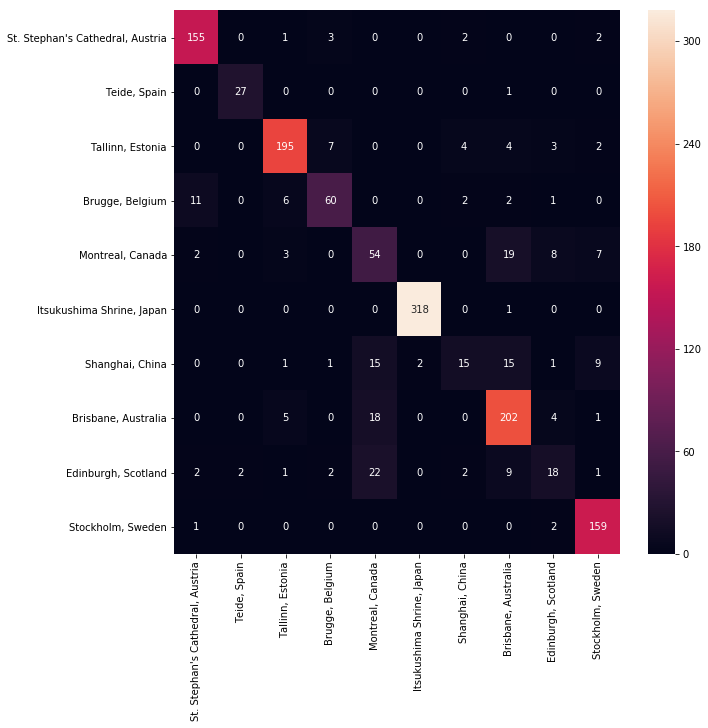

In [20]:
conf_matrix= np.load('conf_mtx.npy')
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

names = landmarks.values() #get names of labels
df_conf_mtx = pd.DataFrame(conf_matrix.astype(int), index = names, columns = names)
plt.figure(figsize = (10,10))
sns.heatmap(df_conf_mtx, annot= True, fmt = 'g')

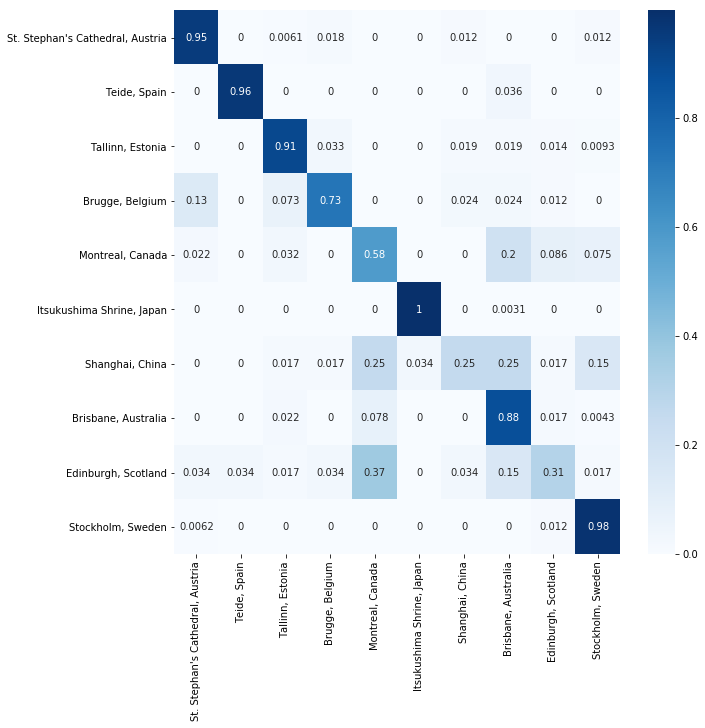

In [25]:
norm_conf_matx = normalize_conf_mtx(conf_matrix)

df_conf_mtx = pd.DataFrame(norm_conf_matx, index = names, columns = names)
plt.figure(figsize = (10,10))
sns.heatmap(df_conf_mtx, annot= True, cmap = 'Blues') #seems to be rounding to 1.0 on heatmap.


In [26]:
print(np.diag(norm_conf_matx))
print(np.argmax(np.diag(norm_conf_matx)))

#class 5 (Itsukushima Shrine, Japan) is most accurate per the maximum value on the normalized confusion matrix with 99.6% accuracy.


[0.95092025 0.96428571 0.90697674 0.73170732 0.58064516 0.9968652
 0.25423729 0.87826087 0.30508475 0.98148148]
5


In [27]:
print(np.diag(norm_conf_matx))
print(np.argmin(np.diag(norm_conf_matx)))

# Class 6 (Shanghai, China) is the least accurate per the diagonal of the matrix (25.4% accuracy).

[0.95092025 0.96428571 0.90697674 0.73170732 0.58064516 0.9968652
 0.25423729 0.87826087 0.30508475 0.98148148]
6


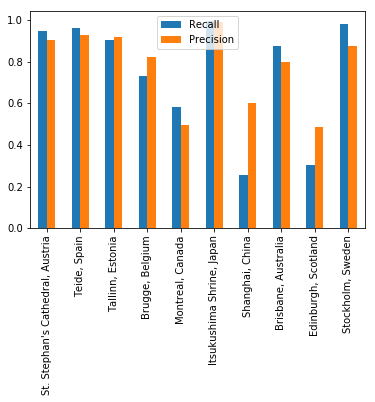

In [29]:
prec_recall_plot(conf_matrix)

In [31]:
# avg accuracy
import numpy as np
print(np.mean(np.diag(norm_conf_matx)))

0.7550464770940787
